# Music Genre Classification Using MLP Neural Network

Classify music by genres ranging from rock and blues to classical. The data has 264 features and 4363 songs selected from the Million Song Dataset. For the MLP classifier two accuracy metrics are used: classification accuracy and log-loss for each genre. The music genres used for the data set are
1. Pop_Rock, 2. Electronic, 3. Rap, 4. Jazz, 5. Latin, 6. RnB, 7. International, 8. Country, 9. Reggae and 10. Blues.

## Libraries and Data Loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from scipy.special import expit

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix

In [2]:
x = pd.read_csv('train_data.csv',header=None)
label = np.array(pd.read_csv('train_labels.csv', header=None))
label = np.subtract(label,1)

print("Training data shape:", x.shape)
print("Training labels shape:", label.shape)
print("\n---Label counts---")
label_count = np.zeros((10,1))
for i in range(label.shape[0]):
        label_count[label[i]] += 1
for i in range(0,10):
    print("Label", i+1,"="  , label_count[i])

Training data shape: (4363, 264)
Training labels shape: (4363, 1)

---Label counts---
Label 1 = [2178.]
Label 2 = [618.]
Label 3 = [326.]
Label 4 = [253.]
Label 5 = [214.]
Label 6 = [260.]
Label 7 = [141.]
Label 8 = [195.]
Label 9 = [92.]
Label 10 = [86.]


# Principal Component Analysis

Principal component analysis (PCA) has been chosen to remove redundant information from the data set. The data is first normalized with Sklearn's standard scaler followed by calculating eigenvalues $\lambda$ and eigenvectors.
Figure 1 below shows the total explained variance of the principal components. The first 40 principal components explain approximately 81% of the total variance and the first 175 principal components explain about 99.2% of the total variance. 

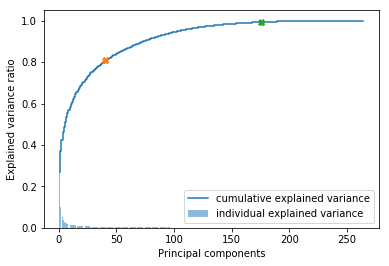

Shape of X after eigenvector transformation
(4363, 175)


In [3]:
#standard scaling and eigenvalues
sc = StandardScaler()
X_std = sc.fit_transform(x)
cov_mat = np.cov(X_std.T)
eigen_values, eigen_vectors = np.linalg.eig(cov_mat)

#Calculate and plot explained variance
total = sum(eigen_values)
variance_exp = [(i / total) for i in sorted(eigen_values, reverse=True)]
cum_var_exp = np.cumsum(variance_exp)
plt.bar(range(1,265), variance_exp, alpha=0.5, align='center',label='individual explained variance')
plt.step(range(1,265), cum_var_exp, where='mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.plot(40,0.81,'X')
plt.plot(175,0.992,'X')
plt.show()

#Transform data by eigenvectors
w = eigen_vectors[:,0:175]
X_pca = X_std.dot(w)
print("Shape of X after eigenvector transformation")
print(X_pca.shape)

# Train-test split

The labels are unevenly distributed so using stratified shuffle split to keep the correct label ratios for training and test data sets. Test data set size is 25 %.

In [4]:
#
sss = StratifiedShuffleSplit(n_splits = 2, test_size = 0.25, 
                             random_state=0)
for train_index, test_index in sss.split(X_pca, label):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = label[train_index], label[test_index]
    

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("\n---Label counts---")
label_count = np.zeros((10,1))
for i in range(y_train.shape[0]):
        label_count[y_train[i]] += 1
for i in range(0,10):
    print("Label", i+1,"="  , label_count[i])
    
print("\nTest data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)
print("\n---Label counts---")
label_count = np.zeros((10,1))
for i in range(y_test.shape[0]):
        label_count[y_test[i]] += 1
for i in range(0,10):
    print("Label", i+1,"="  , label_count[i])

Training data shape: (3272, 175)
Training labels shape: (3272, 1)

---Label counts---
Label 1 = [1633.]
Label 2 = [463.]
Label 3 = [244.]
Label 4 = [190.]
Label 5 = [161.]
Label 6 = [195.]
Label 7 = [106.]
Label 8 = [146.]
Label 9 = [69.]
Label 10 = [65.]

Test data shape: (1091, 175)
Test labels shape: (1091, 1)

---Label counts---
Label 1 = [545.]
Label 2 = [155.]
Label 3 = [82.]
Label 4 = [63.]
Label 5 = [53.]
Label 6 = [65.]
Label 7 = [35.]
Label 8 = [49.]
Label 9 = [23.]
Label 10 = [21.]


# Multilayer Perceptron

A multilayer perceptron (MLP) is an artificial neural network that can be split to three parts: input layer, hidden layer and output layer. MLP is a feedforward network that is utilized for supervised learning through backpropagation. The MLP implementation uses sigmoid activation function
$$s = \frac{1}{1+e^{-x}}$$.

In [5]:
class NeuralNetMLP(object):
    def __init__(self, n_output, n_features, n_hidden=30, l1=0.0,
                l2=0.0, epochs=500, eta=0.001, alpha=0.0,
                decrease_const=0.0, shuffle=True, minibatches=1,
                random_state=None):
        np.random.seed(random_state)
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.w1, self.w2 = self._initialize_weights()
        self.l1 = l1
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        
    def _encode_labels(self, y, k):
        onehot = np.zeros((k, y.shape[0]))
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot
        
    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0, 
                                   size=self.n_hidden*(self.n_features+1))
        w1 = w1.reshape(self.n_hidden, self.n_features +1)
        w2 = np.random.uniform(-1.0, 1.0, 
                                   size=self.n_output*(self.n_hidden +1))
        w2 = w2.reshape(self.n_output, self.n_hidden + 1)
        return w1, w2
        
    def _sigmoid(self, z):
        return 1.0/(1.0 + np.exp(-z))
        
    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)
        
    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1]+1))
            X_new[:, 1:] = X
        elif how == 'row':
            X_new = np.ones((X.shape[0]+1,X.shape[1]))
            X_new[1:, :] = X
        else:
            raise AttributeError('How must be col or row')
        return X_new
            
    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column')
        z2 = w1.dot(a1.T)
        a2 = self._sigmoid(z2)
        a2 = self._add_bias_unit(a2, how='row')
        z3 = w2.dot(a2)
        a3 = self._sigmoid(z3)
        return a1, z2, a2, z3, a3
        
    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.sum(w1[:, 1:] ** 2)\
                                   + np.sum(w2[:, 1:] ** 2))
    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_/2.0) * (np.abs(w1[:, 1:].sum())\
                                   + np.abs(w2[:, 1:].sum()))
        
    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost
        
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        sigma3 = a3 - y_enc
        z2 = self._add_bias_unit(z2, how='row')
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2)
        sigma2 = sigma2[1:, :]
        grad1 = sigma2.dot(a1)
        grad2 = sigma3.dot(a2.T)
            
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))
        return grad1, grad2
        
    def predict(self, X):
        a1, z2, a2, z3, a3 = self._feedforward(X, self.w1, self.w2)
        print("z3 shape:", z3.shape)
        y_pred = np.argmax(z3, axis=0)
        return y_pred, z3
        
    def fit(self, X, y, print_progress=False):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)
            
        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
            
        for i in range(self.epochs):
            self.eta /= (1+ self.decrease_const*i)
            if  print_progress:
                print("Epoch:", i+1, self.epochs)
            if self.shuffle:
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]
                    
            mini = np.array_split(range(y_data.shape[0]), self.minibatches)
            for idx in mini:
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                cost = self._get_cost(y_enc=y_enc[:, idx], output=a3, w1=self.w1,w2=self.w2)
                self.cost_.append(cost)
                    
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z2=z2, y_enc=y_enc[:, idx],
                                                     w1=self.w1,w2=self.w2)
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev))
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
        return self

In [ ]:
nn = NeuralNetMLP(n_output=10, n_features=X_pca.shape[1],n_hidden=150,
                 l2=0.1,l1=0.05, epochs=3000, eta=0.001, alpha=0.001,
                 decrease_const=0.00001, shuffle=True,
                 minibatches=50,random_state=1)
nn.fit(X_train, y_train, print_progress=False)

# Label Prediction

In [ ]:
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs * 50')
plt.tight_layout()
plt.show()

In [ ]:
batches = np.array_split(range(len(nn.cost_)), 1000)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0,500])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()

In [ ]:
def calculate_accuracy(y, y_hat):
    N = y.shape[0];
    correct = 0;
    for i in range(N):
        if (y[i] == y_hat[i]):
            correct += 1
    accuracy = round(correct/N,4)*100
    return accuracy

In [ ]:
y_test_pred, probabilities = nn.predict(X_test)
accuracy = calculate_accuracy(y_test, y_test_pred)
print("Prediction shape:",y_test_pred.shape)
logloss = np.transpose(probabilities)
scaler = MinMaxScaler(copy=True, feature_range=(0,1))
logloss = scaler.fit_transform(logloss)
print("Probabilities shape:", logloss.shape,"\n")
print("Labeling accuracy")
print(accuracy)

print("\n---Label counts---")
label_count2 = np.zeros((10,1))
for i in range(y_test_pred.shape[0]):
        label_count2[y_test_pred[i]] += 1
for i in range(0,10):
    print("Label", i+1,"="  , label_count2[i])

In [ ]:
print("log loss:")
print(log_loss(y_test, probabilities.T))
print("\nConfusion matrix:")
confusion_matrix(y_test, y_test_pred)

# References
[1] Sklearn. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

[2] Lay, D. Lay. S, McDonald, J. Linear Algebra and its Applications. 5th Ed. Harlow, England: Pearson, 2016. ISBN 978-1-292-09223-2. 